In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import lightgbm as lgb

import xgboost as xgb
from xgboost.callback import EarlyStopping

from sklearn.preprocessing import LabelEncoder


In [ ]:
# Load Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [24]:
!pip uninstall xgboost -y
!conda uninstall xgboost -y
!pip install xgboost==1.7.6


Found existing installation: xgboost 1.7.6
Uninstalling xgboost-1.7.6:
  Successfully uninstalled xgboost-1.7.6



PackagesNotFoundError: The following packages are missing from the target environment:
  - xgboost




  Using cached xgboost-1.7.6-py3-none-win_amd64.whl.metadata (1.9 kB)
Using cached xgboost-1.7.6-py3-none-win_amd64.whl (70.9 MB)


[0]	train-rmse:273.02360	eval-rmse:277.63418
[100]	train-rmse:43.88143	eval-rmse:51.42235
[200]	train-rmse:38.44329	eval-rmse:50.58683
[300]	train-rmse:34.67041	eval-rmse:50.47213
[400]	train-rmse:31.36733	eval-rmse:50.42968
[408]	train-rmse:31.15886	eval-rmse:50.44778
Validation RMSE: 50.4463


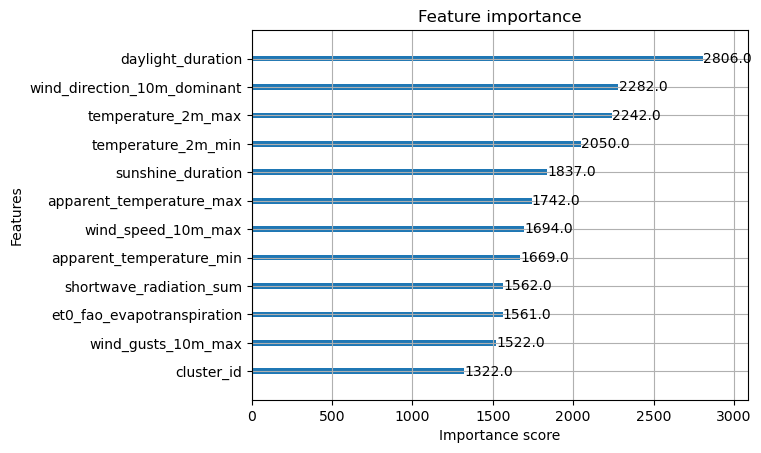

Submission file saved.


In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Preprocessing
train['cluster_id'] = train['cluster_id'].astype('category')
test['cluster_id'] = test['cluster_id'].astype('category')

# Fill missing with median
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

# Handle outliers
for col in ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max', 
            'apparent_temperature_min', 'sunshine_duration', 'daylight_duration', 
            'wind_speed_10m_max', 'wind_gusts_10m_max', 'shortwave_radiation_sum', 
            'et0_fao_evapotranspiration']:
    
    q_low = train[col].quantile(0.01)
    q_high = train[col].quantile(0.99)
    
    train[col] = train[col].clip(lower=q_low, upper=q_high)
    test[col] = test[col].clip(lower=q_low, upper=q_high)

# Feature selection
features = [col for col in train.columns if col not in ['ID', 'date', 'electricity_consumption']]

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    train[features], train['electricity_consumption'], test_size=0.2, random_state=42
)

# DMatrix conversion
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(test[features], enable_categorical=True)


# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train with early stopping
evallist = [(dtrain, 'train'), (dval, 'eval')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=50,
    verbose_eval=100
)

# Prediction on validation set
val_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'Validation RMSE: {rmse:.4f}')

# Feature Importance
xgb.plot_importance(model)
plt.show()

# Prediction on test set
test_pred = model.predict(dtest)

# Submission
submission = pd.DataFrame({
    'ID': test['ID'],
    'electricity_consumption': test_pred
})

submission.to_csv('submission_xgb.csv', index=False)
print('Submission file saved.')


CATBOOST

In [28]:
!pip install catboost
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Preprocessing
train['cluster_id'] = train['cluster_id'].astype('category')
test['cluster_id'] = test['cluster_id'].astype('category')

features = [col for col in train.columns if col not in ['ID', 'date', 'electricity_consumption']]

X_train, X_val, y_train, y_val = train_test_split(
    train[features], train['electricity_consumption'], test_size=0.2, random_state=42
)

# Categorical feature indices
cat_features = [X_train.columns.get_loc('cluster_id')]

# Model
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_features
)

# Evaluation
val_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'Validation RMSE: {rmse:.4f}')

# Test prediction
test_pred = model.predict(test[features])

# Submission
submission = pd.DataFrame({
    'ID': test['ID'],
    'electricity_consumption': test_pred
})
submission.to_csv('submission_catboost.csv', index=False)


   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/102.4 MB 4.5 MB/s eta 0:00:23
   ---------------------------------------- 0.2/102.4 MB 4.1 MB/s eta 0:00:25
   ---------------------------------------- 0.3/102.4 MB 2.3 MB/s eta 0:00:46
   ---------------------------------------- 0.3/102.4 MB 1.8 MB/s eta 0:00:58
   ---------------------------------------- 0.4/102.4 MB 2.2 MB/s eta 0:00:46
   ---------------------------------------- 0.4/102.4 MB 1.7 MB/s eta 0:00:59
   ---------------------------------------- 0.5/102.4 MB 1.7 MB/s eta 0:00:59
   ---------------------------------------- 0.5/102.4 MB 1.9 MB/s eta 0:00:55
   ---------------------------------------- 0.6/102.4 MB 1.7 MB/s eta 0:00:59
   ---------------------------------------- 0.6/102.4 MB 1.7 MB/s eta 0:01:01
   ---------------------------------------- 0.7/102.4 MB 1.7 MB/s eta 0:01:01
   ---------------------------------------- 0.8/102.4 MB 1.6 MB/s eta 0

LIGHTGBM

In [ ]:
train.isnull().sum() 

In [ ]:
train.describe()

In [ ]:
print(train['cluster_id'].unique())

In [ ]:
train[train['wind_gusts_10m_max'] > 70]

In [ ]:
train['month'] = pd.to_datetime(train['date']).dt.month
train['day'] = pd.to_datetime(train['date']).dt.day
test['month'] = pd.to_datetime(test['date']).dt.month
test['day'] = pd.to_datetime(test['date']).dt.day


In [ ]:
le = LabelEncoder()
train['cluster_id'] = le.fit_transform(train['cluster_id'])
test['cluster_id'] = le.transform(test['cluster_id'])


In [ ]:

features = [col for col in train.columns if col not in ['ID', 'date', 'electricity_consumption']]
X = train[features]
y = train['electricity_consumption']
X_test = test[features]

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM Model
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

In [ ]:
# Validation
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Validation RMSE: {rmse}')

# Predict on Test Set
test['electricity_consumption'] = model.predict(X_test)


In [ ]:
submission = test[['ID', 'electricity_consumption']]
submission.to_csv('submission2.csv', index=False)


Linear


In [ ]:
# Feature Selection
features = [
    'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
    'apparent_temperature_min', 'sunshine_duration', 'daylight_duration',
    'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant',
    'shortwave_radiation_sum', 'et0_fao_evapotranspiration'
]



In [ ]:
X = train[features]
y = train['electricity_consumption']
X_test = test[features]



In [ ]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train Baseline Model
model = LinearRegression()
model.fit(X_train, y_train)


In [ ]:
# Evaluate
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'Validation RMSE: {rmse:.4f}')

In [ ]:
# Predict on Test Set
test['electricity_consumption'] = model.predict(X_test)

In [ ]:
# Prepare Submission
submission = test[['ID', 'electricity_consumption']]
submission.to_csv('baseline_submission.csv', index=False)
print('Baseline submission file created: baseline_submission.csv')